In [ ]:
import gensim
import pandas as pd
import keras
import pickle
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filename='preprocessed_data.pkl'

In [ ]:
data=pickle.load(open(filename,'rb')) ###open preprocessed data

In [ ]:
len(data)

8450

In [ ]:
Y= data.iloc[:,1].values
Y

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
###Manually resolve the tabbed data errors

index = [791,  792,  793,  830,  831,  832,  833,  839,  844, 846, 852,  853,
         855,  858,  860,  876,  882,  890,  892,  904,  909,  912,  936,
         938,  943,  945,  957,  964,  965,  967,  969,  972,  975,  976,
        1000, 1007, 1013, 1018, 1297] 
for i in index:
    Y[i] = 0  ###replace value of selected indices of AD column with 0

idx = [1072, 1101, 1184, 1244]
for i in idx:
    Y[i] = 1  ###replace value of selected indices of AD column with 1
Y = Y.astype(int)

In [ ]:
X = data['Transcript'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 0) ##split the data in training and testing

In [ ]:
print(len(X_train)) ###length of training, testing data
print(len(X_test))
print(len(Y_train))
print(len(Y_test))

6760
1690
6760
1690


In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [ ]:
train_tokenizer = create_tokens(X_train)

In [ ]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X

In [ ]:
X_train = encode_sentences(train_tokenizer,100, X_train)
X_test = encode_sentences(train_tokenizer,100, X_test)

In [ ]:
print(X_train.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(6760, 100)
(1690, 100)
(6760,)
(1690,)


In [ ]:
vocab_len= len(train_tokenizer.word_index ) + 1 
vocab_len   ###vocab length

8741

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D, LSTM, Bidirectional
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dense 
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
model = Sequential()
e = Embedding(vocab_len, 100, input_length= 100)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(20)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn_lstm_history=model.fit(X_train, Y_train, epochs = 5, batch_size = 64, verbose = 1, validation_split = 0.1)

Epoch 1/5
96/96 [==============================] - 12s 79ms/step - loss: 0.3414 - accuracy: 0.9311 - val_loss: 0.1645 - val_accuracy: 0.9393
Epoch 2/5
96/96 [==============================] - 6s 66ms/step - loss: 0.1374 - accuracy: 0.9425 - val_loss: 0.1128 - val_accuracy: 0.9615
Epoch 3/5
96/96 [==============================] - 6s 66ms/step - loss: 0.0608 - accuracy: 0.9805 - val_loss: 0.1210 - val_accuracy: 0.9615
Epoch 4/5
96/96 [==============================] - 6s 66ms/step - loss: 0.0314 - accuracy: 0.9913 - val_loss: 0.1392 - val_accuracy: 0.9541
Epoch 5/5
96/96 [==============================] - 6s 66ms/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.1548 - val_accuracy: 0.9586


In [ ]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 1s 10ms/step - loss: 0.1415 - accuracy: 0.9633


0.963313639163971

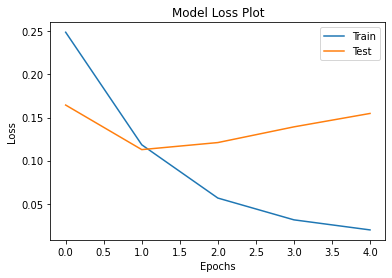

In [ ]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_lstm_history.history['loss'])
plt.plot(cnn_lstm_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [ ]:
model.save('cnn_lstm_model.hdf5')   ###save the model

In [ ]:
model.load_weights('cnn_lstm_model.hdf5')

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[1564   26]
 [  36   64]]
precision is 0.7111111111111111
recall is  0.64
F1 score 0.6736842105263158
specificity is 0.9836477987421384


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


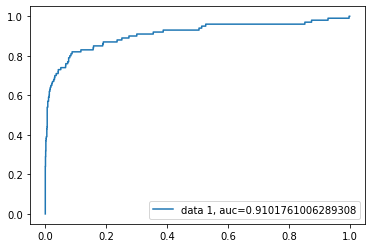

In [ ]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
embeddings = dict()      
example1 = "/content/drive/MyDrive/glove.6B.50d.txt"
                           ##read glove vector file
f = open(example1, "r")
for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:],dtype='float32')
    embeddings[word]=vectors
f.close()

In [ ]:
embedding_matrix = np.zeros((vocab_len, 50))      ###create a matrix consist of words and its vectors
for word, i in train_tokenizer.word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:

model = Sequential()
e = Embedding(vocab_len, 50, input_length= 100, weights = [embedding_matrix], trainable= False)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=3,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(128)))
model.add(Dropout(0.2))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn_lstm_pretrained_history=model.fit(X_train, Y_train, epochs = 3, batch_size = 64, verbose = 1, validation_split = 0.1)

Epoch 1/3
96/96 [==============================] - 16s 131ms/step - loss: 0.2469 - accuracy: 0.9216 - val_loss: 0.1383 - val_accuracy: 0.9497
Epoch 2/3
96/96 [==============================] - 12s 121ms/step - loss: 0.1206 - accuracy: 0.9555 - val_loss: 0.1133 - val_accuracy: 0.9556
Epoch 3/3
96/96 [==============================] - 12s 120ms/step - loss: 0.1009 - accuracy: 0.9628 - val_loss: 0.0988 - val_accuracy: 0.9645


In [ ]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 1s 16ms/step - loss: 0.1086 - accuracy: 0.9639


0.9639053344726562

In [ ]:
def model_cnn_lstm_create(optimizer = 'Adam',
                 dropout_rate = 0.2, nb_filters = 256, kernel_size = 5,pool_size=4,units = 128):
    
    model = Sequential()
    e = Embedding(vocab_len, 50, input_length= 100, weights = [embedding_matrix], trainable= False)
    model.add(e)
    model.add(Conv1D(nb_filters, kernel_size, activation = 'relu',strides = 1, kernel_initializer= 'he_uniform'))   
    model.add(MaxPooling1D(pool_size = pool_size))
    model.add(Bidirectional(LSTM(units)))
    model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))   
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [ ]:
param_grid = {
    'units': [10,20,64,128]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 1)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2
169/169 - 8s - loss: 0.2196 - accuracy: 0.9342
Epoch 2/2
169/169 - 5s - loss: 0.1319 - accuracy: 0.9432
43/43 - 1s - loss: 0.1321 - accuracy: 0.9519
[CV] ......................................... units=10, total=  15.5s
[CV] units=10 ........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.5s remaining:    0.0s


Epoch 1/2
169/169 - 8s - loss: 0.2148 - accuracy: 0.9331
Epoch 2/2
169/169 - 5s - loss: 0.1223 - accuracy: 0.9588
43/43 - 1s - loss: 0.1285 - accuracy: 0.9519
[CV] ......................................... units=10, total=  14.9s
[CV] units=10 ........................................................
Epoch 1/2
169/169 - 8s - loss: 0.1978 - accuracy: 0.9351
Epoch 2/2
169/169 - 5s - loss: 0.1211 - accuracy: 0.9584
43/43 - 1s - loss: 0.0979 - accuracy: 0.9689
[CV] ......................................... units=10, total=  15.5s
[CV] units=10 ........................................................
Epoch 1/2
169/169 - 8s - loss: 0.1847 - accuracy: 0.9375
Epoch 2/2
169/169 - 5s - loss: 0.1107 - accuracy: 0.9638
43/43 - 1s - loss: 0.1021 - accuracy: 0.9660
[CV] ......................................... units=10, total=  14.9s
[CV] units=10 ........................................................
Epoch 1/2
169/169 - 8s - loss: 0.1758 - accuracy: 0.9451
Epoch 2/2
169/169 - 5s - loss: 0.1131 - 

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  7.7min finished


Epoch 1/2
212/212 - 26s - loss: 0.1434 - accuracy: 0.9506
Epoch 2/2
212/212 - 22s - loss: 0.0871 - accuracy: 0.9695
Best accuracy:  0.9639053225517273
Best parameters:  {'units': 128}


In [ ]:
param_grid = {
    'optimizer': ['RMSprop','Adam','SGD'],
}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 2)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] optimizer=RMSprop ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2
169/169 - 20s - loss: 0.1479 - accuracy: 0.9449
Epoch 2/2
169/169 - 17s - loss: 0.0955 - accuracy: 0.9669
43/43 - 2s - loss: 0.1106 - accuracy: 0.9623
[CV] ................................ optimizer=RMSprop, total=  40.4s
[CV] optimizer=RMSprop ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.4s remaining:    0.0s


Epoch 1/2
169/169 - 20s - loss: 0.1504 - accuracy: 0.9443
Epoch 2/2
169/169 - 18s - loss: 0.0927 - accuracy: 0.9697
43/43 - 2s - loss: 0.1195 - accuracy: 0.9549
[CV] ................................ optimizer=RMSprop, total=  41.1s
[CV] optimizer=RMSprop ...............................................
Epoch 1/2
169/169 - 20s - loss: 0.1503 - accuracy: 0.9514
Epoch 2/2
169/169 - 17s - loss: 0.0992 - accuracy: 0.9671
43/43 - 2s - loss: 0.0951 - accuracy: 0.9734
[CV] ................................ optimizer=RMSprop, total=  40.1s
[CV] optimizer=RMSprop ...............................................
Epoch 1/2
169/169 - 21s - loss: 0.1498 - accuracy: 0.9506
Epoch 2/2
169/169 - 17s - loss: 0.0978 - accuracy: 0.9654
43/43 - 2s - loss: 0.0947 - accuracy: 0.9719
[CV] ................................ optimizer=RMSprop, total=  40.5s
[CV] optimizer=RMSprop ...............................................
Epoch 1/2
169/169 - 20s - loss: 0.1478 - accuracy: 0.9456
Epoch 2/2
169/169 - 17s - loss: 0

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed: 10.0min finished


Epoch 1/2
212/212 - 26s - loss: 0.1436 - accuracy: 0.9478
Epoch 2/2
212/212 - 23s - loss: 0.0919 - accuracy: 0.9706
Best accuracy:  0.9650887608528137
Best parameters:  {'optimizer': 'RMSprop'}


In [ ]:
param_grid = {
    'nb_filters': [128,256],
    'kernel_size':[3,5]

}                                                             ####perform grid search to find the hyperparameters

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 2)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] kernel_size=3, nb_filters=128 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2
169/169 - 13s - loss: 0.1733 - accuracy: 0.9419
Epoch 2/2
169/169 - 10s - loss: 0.1038 - accuracy: 0.9628
43/43 - 1s - loss: 0.1544 - accuracy: 0.9541
[CV] .................... kernel_size=3, nb_filters=128, total=  24.5s
[CV] kernel_size=3, nb_filters=128 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.5s remaining:    0.0s


Epoch 1/2
169/169 - 12s - loss: 0.1688 - accuracy: 0.9373
Epoch 2/2
169/169 - 10s - loss: 0.1020 - accuracy: 0.9663
43/43 - 1s - loss: 0.1228 - accuracy: 0.9593
[CV] .................... kernel_size=3, nb_filters=128, total=  24.0s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/2
169/169 - 12s - loss: 0.1723 - accuracy: 0.9368
Epoch 2/2
169/169 - 10s - loss: 0.1089 - accuracy: 0.9604
43/43 - 1s - loss: 0.1029 - accuracy: 0.9660
[CV] .................... kernel_size=3, nb_filters=128, total=  23.6s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/2
169/169 - 12s - loss: 0.1685 - accuracy: 0.9405
Epoch 2/2
169/169 - 10s - loss: 0.1039 - accuracy: 0.9636
43/43 - 1s - loss: 0.1028 - accuracy: 0.9660
[CV] .................... kernel_size=3, nb_filters=128, total=  24.6s
[CV] kernel_size=3, nb_filters=128 ...................................
Epoch 1/2
169/169 - 12s - loss: 0.1661 - accuracy: 0.9423
Epoch 2/2
169/169 - 10s - loss: 0

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 10.6min finished


Epoch 1/2
212/212 - 24s - loss: 0.1559 - accuracy: 0.9448
Epoch 2/2
212/212 - 21s - loss: 0.0983 - accuracy: 0.9661
Best accuracy:  0.9628698229789734
Best parameters:  {'kernel_size': 3, 'nb_filters': 256}


In [ ]:
param_grid = {
    'dropout_rate': [0.1,0.2,0.3,0.4,0.5]
}             

model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 2)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2
169/169 - 20s - loss: 0.1632 - accuracy: 0.9429
Epoch 2/2
169/169 - 17s - loss: 0.0959 - accuracy: 0.9665
43/43 - 2s - loss: 0.1191 - accuracy: 0.9660
[CV] ................................. dropout_rate=0.1, total=  40.4s
[CV] dropout_rate=0.1 ................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   40.4s remaining:    0.0s


Epoch 1/2
169/169 - 20s - loss: 0.1606 - accuracy: 0.9414
Epoch 2/2
169/169 - 17s - loss: 0.0913 - accuracy: 0.9702
43/43 - 2s - loss: 0.1159 - accuracy: 0.9534
[CV] ................................. dropout_rate=0.1, total=  39.4s
[CV] dropout_rate=0.1 ................................................
Epoch 1/2
169/169 - 20s - loss: 0.1617 - accuracy: 0.9458
Epoch 2/2
169/169 - 17s - loss: 0.0949 - accuracy: 0.9662
43/43 - 2s - loss: 0.0956 - accuracy: 0.9719
[CV] ................................. dropout_rate=0.1, total=  40.2s
[CV] dropout_rate=0.1 ................................................
Epoch 1/2
169/169 - 20s - loss: 0.1621 - accuracy: 0.9449
Epoch 2/2
169/169 - 17s - loss: 0.0991 - accuracy: 0.9665
43/43 - 2s - loss: 0.0944 - accuracy: 0.9712
[CV] ................................. dropout_rate=0.1, total=  39.6s
[CV] dropout_rate=0.1 ................................................
Epoch 1/2
169/169 - 21s - loss: 0.1674 - accuracy: 0.9408
Epoch 2/2
169/169 - 17s - loss: 0

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 16.6min finished


Epoch 1/2
212/212 - 26s - loss: 0.1532 - accuracy: 0.9464
Epoch 2/2
212/212 - 22s - loss: 0.0962 - accuracy: 0.9679
Best accuracy:  0.965680468082428
Best parameters:  {'dropout_rate': 0.4}


In [ ]:
param_grid = {
    'batch_size': [32,64,128,256]
}                                                             ####perform grid search to find the hyperparameters
model = KerasClassifier(build_fn = model_cnn_lstm_create, verbose = 2)
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, verbose = 2)
grid_results = grid_search.fit(X_train, Y_train, epochs = 1)
print('Best accuracy: ', grid_results.best_score_)
print('Best parameters: ', grid_results.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


169/169 - 20s - loss: 0.1622 - accuracy: 0.9456
43/43 - 2s - loss: 0.1411 - accuracy: 0.9578
[CV] .................................... batch_size=32, total=  22.5s
[CV] batch_size=32 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.5s remaining:    0.0s


169/169 - 20s - loss: 0.1690 - accuracy: 0.9395
43/43 - 2s - loss: 0.1471 - accuracy: 0.9527
[CV] .................................... batch_size=32, total=  23.0s
[CV] batch_size=32 ...................................................
169/169 - 20s - loss: 0.1673 - accuracy: 0.9449
43/43 - 2s - loss: 0.1120 - accuracy: 0.9564
[CV] .................................... batch_size=32, total=  22.3s
[CV] batch_size=32 ...................................................
169/169 - 20s - loss: 0.1608 - accuracy: 0.9449
43/43 - 2s - loss: 0.1199 - accuracy: 0.9675
[CV] .................................... batch_size=32, total=  22.9s
[CV] batch_size=32 ...................................................
169/169 - 20s - loss: 0.1548 - accuracy: 0.9486
43/43 - 2s - loss: 0.1335 - accuracy: 0.9549
[CV] .................................... batch_size=32, total=  22.4s
[CV] batch_size=64 ...................................................
85/85 - 18s - loss: 0.1851 - accuracy: 0.9325
22/22 - 2s - l

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  6.2min finished


212/212 - 26s - loss: 0.1506 - accuracy: 0.9501
Best accuracy:  0.9578402400016784
Best parameters:  {'batch_size': 32}


In [ ]:
model = Sequential()
e = Embedding(vocab_len, 50, input_length= 100, weights = [embedding_matrix], trainable= False)
model.add(e)
model.add(Conv1D(filters=128,kernel_size=5,activation='relu',strides= 1, kernel_initializer='he_uniform'))
model.add(MaxPooling1D(pool_size=4))
model.add(Bidirectional(LSTM(10)))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_uniform'))
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn_lstm_pretrained_history=model.fit(X_train, Y_train, epochs = 1, batch_size = 128, verbose = 1, validation_split = 0.1)

48/48 [==============================] - 7s 87ms/step - loss: 0.4418 - accuracy: 0.8374 - val_loss: 0.2156 - val_accuracy: 0.9393


In [ ]:
score = model.evaluate(X_test,Y_test,verbose = 1)
score[1]

53/53 [==============================] - 0s 9ms/step - loss: 0.2058 - accuracy: 0.9408


0.9408283829689026

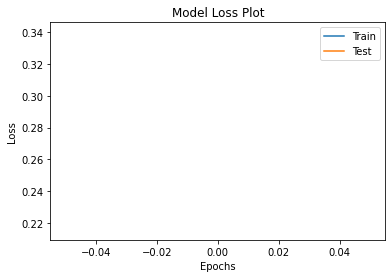

In [ ]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(cnn_lstm_pretrained_history.history['loss'])
plt.plot(cnn_lstm_pretrained_history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'],loc = 'upper right')
plt.show()

In [ ]:
model.save('cnn_lstm_pretrained_model.hdf5')   ###save the model

In [ ]:
model.load_weights('cnn_lstm_pretrained_model.hdf5')

In [ ]:
Y_pred = model.predict(X_test)
Y_pred = (Y_pred >0.5)

In [ ]:
confusion = confusion_matrix(Y_test,Y_pred)        ###Model evaluation
precision = precision_score(Y_test,Y_pred)
recall = recall_score(Y_test,Y_pred)
F1 = f1_score(Y_test,Y_pred)
specificity = (confusion[0][0]/(confusion[0][0]+confusion[0][1]))
print('confusion matrix {}'.format(confusion))
print('precision is {}'.format(precision))
print('recall is  {}'.format(recall))
print('F1 score {}'.format(F1))
print('specificity is {}'.format(specificity))

confusion matrix [[1590    0]
 [ 100    0]]
precision is 0.0
recall is  0.0
F1 score 0.0
specificity is 1.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


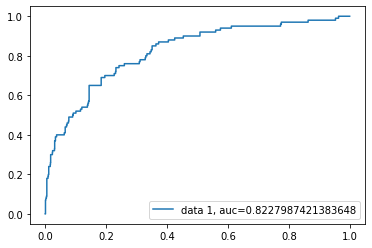

In [ ]:
Y_pred_proba = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)
auc = roc_auc_score(Y_test, Y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Dropout, Convolution2D, Conv2D, MaxPooling2D, Lambda, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation, AveragePooling2D, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils

%matplotlib inline


In [ ]:
batch_size=64

gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10
                        )


In [ ]:
def get_callbacks(name_weights, patience_lr):
    mcp_save = ModelCheckpoint(name_weights, save_best_only=True, monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, epsilon=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss]


In [ ]:
for j, (train_idx, val_idx) in enumerate(folds):
    
    print('\nFold ',j)
    X_train_cv = X_train[train_idx]
    y_train_cv = y_train[train_idx]
    X_valid_cv = X_train[val_idx]
    y_valid_cv= y_train[val_idx]
    
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=10)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = batch_size)
    model = get_model()
    model.fit_generator(
                generator,
                steps_per_epoch=len(X_train_cv)/batch_size,
                epochs=15,
                shuffle=True,
                verbose=1,
                validation_data = (X_valid_cv, y_valid_cv),
                callbacks = callbacks)
    
    print(model.evaluate(X_valid_cv, y_valid_cv))


NameError: ignored